In [1]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from itertools import product

In [2]:
# Função para carregar os dados
def carregar_dados():
    caminho_producao = r"C:\Users\lucas\Downloads\dados_producao.csv"
    df_producao = pd.read_csv(caminho_producao)

    # Transformar ano em datetime e verificar duplicatas
    df_producao['ano'] = pd.to_datetime(df_producao['ano'], format='%Y')
    
    # Remover duplicatas somando valores de 'total_litros' para o mesmo ano
    df_producao = df_producao.groupby('ano').agg({'total_litros': 'sum'}).reset_index()

    # Definir 'ano' como índice e garantir a frequência anual
    df_producao.set_index('ano', inplace=True)
    df_producao = df_producao.asfreq('YS')  # Definir a frequência anual
    
    return df_producao

In [3]:
# Testar se a série é estacionária com o ADF Test
def testar_estacionariedade(serie):
    resultado_adf = adfuller(serie)
    print(f"Estatística de Teste ADF: {resultado_adf[0]}")
    print(f"Valor-p: {resultado_adf[1]}")
    if resultado_adf[1] <= 0.05:
        print("A série é estacionária.")
    else:
        print("A série não é estacionária.")

In [4]:
# Função para diferenciar a série
def diferenciar_serie(df):
    df['y_diff'] = df['total_litros'].diff().dropna()
    return df.dropna()

In [5]:
# Função para normalizar os dados
def normalizar_dados(df):
    scaler = MinMaxScaler()
    df[['y_diff']] = scaler.fit_transform(df[['y_diff']])
    return df, scaler


In [6]:
# Função para treinar o modelo ARIMA
def treinar_arima(df, order):
    modelo = ARIMA(df['y_diff'], order=order)
    modelo_fit = modelo.fit()  # Remover o solver que causava o erro
    previsoes = modelo_fit.forecast(steps=10)
    return modelo_fit, previsoes


In [8]:
# Calcular SMAPE
def calcular_smape(y_true, y_pred):
    return 100 / len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))


In [9]:
# Função para realizar grid search
def grid_search_arima(df, p_values, d_values, q_values):
    best_mae, best_order, best_rmse, best_smape = float("inf"), None, float("inf"), None
    
    for order in product(p_values, d_values, q_values):
        try:
            modelo_fit, previsoes = treinar_arima(df, order)
            
            y_teste = df['y_diff'].tail(10).values  # Últimos 10 valores reais
            y_pred = previsoes[:len(y_teste)]
            
            mae = mean_absolute_error(y_teste, y_pred)
            rmse = np.sqrt(mean_squared_error(y_teste, y_pred))
            smape = calcular_smape(y_teste, y_pred)
            
            if mae < best_mae:
                best_mae, best_order, best_rmse, best_smape = mae, order, rmse, smape
                print(f"Melhor ordem atual {order} com MAE: {mae}, RMSE: {rmse}, SMAPE: {smape:.2f}%")
        
        except Exception as e:
            print(f"Erro ao ajustar o modelo ARIMA para ordem {order}: {e}")
    
    if best_order is None:
        print("Nenhum modelo foi ajustado com sucesso.")
    else:
        print(f"Melhores parâmetros encontrados: {best_order} com MAE: {best_mae}, RMSE: {best_rmse}, SMAPE: {best_smape:.2f}%")

In [10]:
# Função para plotar ACF e PACF
def plot_acf_pacf(df):
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plot_acf(df['y_diff'], lags=20, ax=plt.gca())
    plt.title('ACF')
    
    plt.subplot(122)
    plot_pacf(df['y_diff'], lags=20, ax=plt.gca())
    plt.title('PACF')
    
    plt.tight_layout()
    plt.show()

In [11]:
# Função principal
def main():
    df_producao = carregar_dados()

    # Testar estacionariedade antes e depois da diferenciação
    print("Antes da diferenciação:")
    testar_estacionariedade(df_producao['total_litros'])

    df_producao = diferenciar_serie(df_producao)

    print("\nApós a diferenciação:")
    testar_estacionariedade(df_producao['y_diff'])

    # Normalizar os dados
    df_producao, scaler = normalizar_dados(df_producao)

    # Plotar ACF e PACF
    plot_acf_pacf(df_producao)

    # Realizar grid search para ARIMA
    p_values = range(0, 4)
    d_values = range(0, 2)
    q_values = range(0, 4)

    grid_search_arima(df_producao, p_values, d_values, q_values)

Antes da diferenciação:
Estatística de Teste ADF: -0.6827852064978401
Valor-p: 0.8511583112047972
A série não é estacionária.

Após a diferenciação:
Estatística de Teste ADF: -10.32109520985578
Valor-p: 3.007653327330864e-18
A série é estacionária.


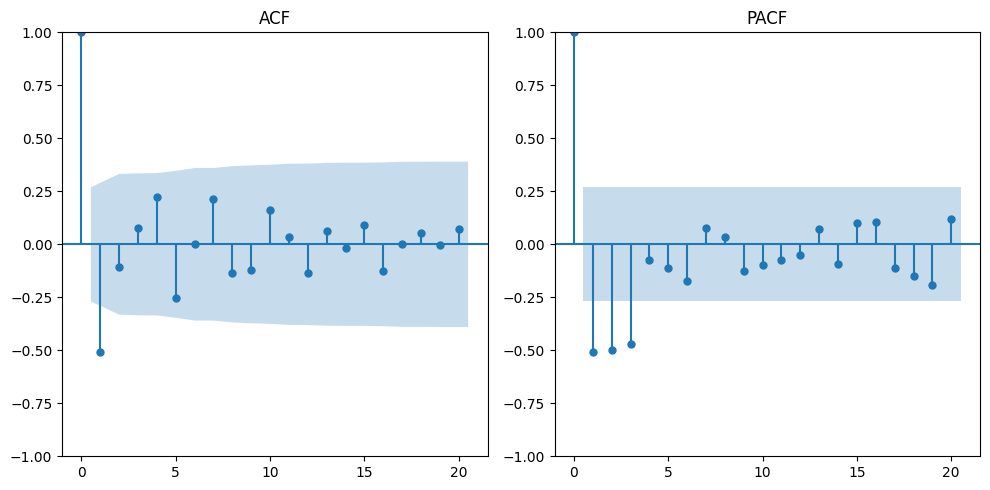

Melhor ordem atual (0, 0, 0) com MAE: 0.18739881573602965, RMSE: 0.2588864175193656, SMAPE: 45.52%


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters

Melhor ordem atual (1, 0, 0) com MAE: 0.18698413907972722, RMSE: 0.2582027915788285, SMAPE: 45.46%
Melhor ordem atual (1, 0, 2) com MAE: 0.18509373360375428, RMSE: 0.24818833381790475, SMAPE: 45.83%


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn(

Melhor ordem atual (3, 0, 0) com MAE: 0.18151571009944725, RMSE: 0.24783487764580273, SMAPE: 45.93%


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Melhor ordem atual (3, 0, 3) com MAE: 0.17969721519880483, RMSE: 0.24319434891034644, SMAPE: 45.76%
Melhor ordem atual (3, 1, 0) com MAE: 0.16469399326640524, RMSE: 0.21700377529446543, SMAPE: 43.16%
Melhores parâmetros encontrados: (3, 1, 0) com MAE: 0.16469399326640524, RMSE: 0.21700377529446543, SMAPE: 43.16%


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [12]:
if __name__ == "__main__":
    main()
